In [24]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import scipy.stats as sp
import matplotlib.pyplot as plt
import json
import logging
import warnings
import os


warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=UserWarning)

logger = logging.getLogger("pymc")
logger.setLevel(logging.ERROR)



class WassersteinExample:
    
    def __init__(self, means, weights=[1,1]):
        self.model = self._bimodal_posterior(weights)
    
    def _bimodal_posterior(self, weights=[1,1]):        
        with pm.Model() as model:
            
            # Mixture weights (equal probability for both components)
            w = pm.Dirichlet("w", a=np.array(weights))

            # Component distributions
            mu = pm.Normal.dist(means, 1)
            
            # Mixture distribution
            mixed_normal = pm.Mixture("mixed_normal", w=w, comp_dists=mu)

        return model
    


    def generate_iid_samples(self, means, num_samples=2000, weights=[1,1]):
        """
        Generate IID samples from the bimodal posterior directly.
        """
        # Flip a coin to choose which Gaussian to sample from
        #modes = np.random.choice(means, size=num_samples)
        # transform [4, 1] to [0.8, 0.2]
        weights = np.array(weights) / np.sum(weights)
        modes = np.random.choice(means, size=num_samples, p=weights)
        # Sample from N(mode, 1)
        iid_samples = np.random.normal(loc=modes, scale=1, size=num_samples)
       


        return iid_samples


    def run_sampling(self, 
                     sampler_name, 
                     num_samples=2000, 
                     tune=1000, 
                     num_chains=2, 
                     initvals=None):

        with self.model:

            # Define which sampler to use
            if sampler_name == "Metro":
                sampler = pm.Metropolis()
            elif sampler_name == "HMC":
                sampler = pm.NUTS()
            elif sampler_name == "DEMetro":
                sampler = pm.DEMetropolis()
            else:
                raise ValueError(f"Unknown sampler: {sampler_name}")


            trace = pm.sample(num_samples, tune=tune, step=sampler, initvals= initvals,chains=num_chains, return_inferencedata=True, progressbar=False)
        
            #az.plot_trace(trace, var_names=["mixed_normal"], figsize=(10, 5))
            #plt.suptitle(f"{sampler_name} Samples ({num_chains} Chains)")
            #plt.show()
        
        return trace
    


    def compute_wasserstein_distances(self, trace, iid_samples):
        
        ws_distance = sp.wasserstein_distance(trace.posterior["mixed_normal"].values.flatten(), iid_samples)

        return ws_distance
    

# number of times to repeat the experiment and the configuration number
runs_max = 1
config_number = 1

#Experiment parameters
min_mode_value = 8
max_mode_value = 8
use_custom_chain_init = True
init_description = "half in first mode, half in second mode"
mean_range = [(i, -i) for i in range(min_mode_value, max_mode_value + 1)] 
weights = [1, 1]
num_samples = 10000
num_chains = 10 # must be even for now 
samples_per_chain = num_samples // num_chains

# Define fixed colors for each sampler
sampler_colors = {
    "Metro": "blue",
    "HMC": "red",
    "DEMetro": "green"
}

# ===== CREATE MAIN CONFIG FOLDER =====
config_folder = f"config_{config_number}_with_{runs_max}_runs"
os.makedirs(config_folder)


# Correct path: Save inside the config folder
metadata_filename = os.path.join(config_folder, f"metadata_config_{config_number}.json")

# ===== SAVE METADATA IN MAIN CONFIG FOLDER =====
experiment_metadata = {
    "min_mode": min_mode_value,
    "max_mode": max_mode_value,
    "num_samples": num_samples,
    "num_chains": num_chains,
    "samples_per_chain": samples_per_chain,
    "weights": weights,
    "use_custom_chain_init": use_custom_chain_init,
    "chain_initialization": init_description
}

with open(metadata_filename, "w") as f:
    json.dump(experiment_metadata, f, indent=4)

# Loop over all runs
for run_id in range(1, runs_max + 1):

    print(f"\n===== Starting Experiment Run {run_id} =====\n")
    # ===== CREATE RUN-SPECIFIC FOLDER =====
    run_folder = os.path.join(config_folder, f"run_{run_id}")
    os.makedirs(run_folder)
    results = []

    for means in mean_range:

        #initvals = [
        #    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 1 starts near Mode 1
        #    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 2 starts near Mode 1
        #    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 3 starts near Mode 1
        #    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 4 starts near Mode 1
        #    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 5 starts near Mode 1
        #    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 6 starts near Mode 2
        #    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 7 starts near Mode 2
        #    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 8 starts near Mode 2
        #    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 9 starts near Mode 2
        #    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 10 starts near Mode 2
        #]

        initvals = [
            {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]} for _ in range(num_chains//2) # half the chains start near mode 1
        ] + [
            {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]} for _ in range(num_chains//2) # half the chains start near mode 2
        ]
        

        # Initialize model
        framework = WassersteinExample(means=means, weights=weights)
        
        # Generate IID samples
        iid_samples = framework.generate_iid_samples(num_samples=num_samples, means=means, weights=weights)
        
        # Run sampling for all samplers
        for sampler_name in ["Metro", "HMC", "DEMetro"]:
            
            print(f"Running for sampler {sampler_name} with means = {means}")
            trace = framework.run_sampling(sampler_name, num_samples=samples_per_chain, num_chains=num_chains, initvals=initvals)
            ws_distance = framework.compute_wasserstein_distances(trace, iid_samples)
            results.append({"means": means, "sampler": sampler_name, "wasserstein_distance": ws_distance})


        # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    # Extract mode distances (first value of the tuple in "means" column)
    df_results["mode_distance"] = df_results["means"].apply(lambda x: abs(x[0] - x[1]))

    # Sort results
    df_results = df_results.sort_values("mode_distance", ascending=False)

    # create one plot for all samplers
    plt.figure(figsize=(10, 6))

    # Iterate over all samplers and plot the results
    for sampler in df_results["sampler"].unique():
        
        df_sampler = df_results[df_results["sampler"] == sampler]

        # Save CSV files
        csv_filename = os.path.join(run_folder, f"Wasserstein_results_{sampler}.csv")
        df_sampler.to_csv(csv_filename, index=False)

        # Add plot 
        plt.plot(df_sampler["mode_distance"], df_sampler["wasserstein_distance"], marker="o", linestyle="-", label=sampler, color=sampler_colors.get(sampler, "black"))


    # Label and save plot
    plt.xlabel("Mode Distance (|Mean1 - Mean2|)")
    plt.ylabel("Wasserstein Distance")
    plt.title("Wasserstein Distance vs Mode Distance for All Samplers")
    plt.legend(title="Sampler")
    plt.grid(True)

    plot_filename = os.path.join(run_folder, f"Wasserstein_plot_run_{run_id}.pdf")
    plt.savefig(plot_filename, bbox_inches="tight")
    plt.close() 

print("\n===== All Runs Completed Successfully! =====\n")

# ===== GLOBAL RESULTS FOLDER =====
global_folder = os.path.join(config_folder, "global_results")
os.makedirs(global_folder, exist_ok=True)

# Collect all results from all runs
df_all_runs = []

for run_id in range(1, runs_max + 1):
    run_folder = os.path.join(config_folder, f"run_{run_id}")

    for sampler in ["Metro", "HMC", "DEMetro"]:
        csv_filename = os.path.join(run_folder, f"Wasserstein_results_{sampler}.csv")
        df_run = pd.read_csv(csv_filename)
        df_run["run_id"] = run_id  # Add run identifier
        df_run["sampler"] = sampler  # Ensure sampler name is retained
        df_all_runs.append(df_run)

# Combine all run results into a single DataFrame
df_all_runs = pd.concat(df_all_runs, ignore_index=True)

# Ensure means are stored as tuples (convert from string if necessary)
df_all_runs["means"] = df_all_runs["means"].apply(eval)

# Pivot data to have separate columns for each run's Wasserstein distance
df_pivot = df_all_runs.pivot_table(
    index="means", 
    columns="run_id", 
    values="wasserstein_distance"
).reset_index()

# Rename run columns
df_pivot.columns = ["means"] + [f"Run_{col}" for col in df_pivot.columns[1:]]

# Compute the global average for each row
df_pivot["global_avg"] = df_pivot.iloc[:, 1:].mean(axis=1)

# Extract mode distances
df_pivot["mode_distance"] = df_pivot["means"].apply(lambda x: abs(x[0] - x[1]))

# ===== SAVE INDIVIDUAL CSVs FOR EACH SAMPLER =====
for sampler in ["Metro", "HMC", "DEMetro"]:
    df_sampler = df_all_runs[df_all_runs["sampler"] == sampler]

    # Pivot again for this specific sampler
    df_sampler_pivot = df_sampler.pivot_table(
        index="means", 
        columns="run_id", 
        values="wasserstein_distance"
    ).reset_index()

    # Rename run columns
    df_sampler_pivot.columns = ["means"] + [f"Run_{col}" for col in df_sampler_pivot.columns[1:]]

    # Compute global average for this sampler
    df_sampler_pivot["global_avg"] = df_sampler_pivot.iloc[:, 1:].mean(axis=1)

    # Extract mode distances
    df_sampler_pivot["mode_distance"] = df_sampler_pivot["means"].apply(lambda x: abs(x[0] - x[1]))

    # Save sampler-specific CSV
    sampler_csv_filename = os.path.join(global_folder, f"Wasserstein_global_results_{sampler}.csv")
    df_sampler_pivot.to_csv(sampler_csv_filename, index=False)
    print(f"Global results for {sampler} saved to {sampler_csv_filename}")

# ===== CREATE GLOBAL AVERAGE PLOT =====
plt.figure(figsize=(10, 6))

for sampler in ["Metro", "HMC", "DEMetro"]:
    df_sampler_pivot = pd.read_csv(os.path.join(global_folder, f"Wasserstein_global_results_{sampler}.csv"))
    
    # Plot the global average Wasserstein distances
    plt.plot(df_sampler_pivot["mode_distance"], df_sampler_pivot["global_avg"], 
             marker="o", linestyle="-", label=sampler, 
             color=sampler_colors.get(sampler, "black"))

# Label and save the global plot
plt.xlabel("Mode Distance (|Mean1 - Mean2|)")
plt.ylabel("Average Wasserstein Distance")
plt.title(f"Global Averaged Wasserstein Distance ({runs_max} Runs)")
plt.legend(title="Sampler")
plt.grid(True)

global_plot_filename = os.path.join(global_folder, "Wasserstein_global_plot.pdf")
plt.savefig(global_plot_filename, bbox_inches="tight")
plt.close()



===== Starting Experiment Run 1 =====

Running for sampler Metro with means = (8, -8)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running for sampler HMC with means = (8, -8)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running for sampler DEMetro with means = (8, -8)


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



===== All Runs Completed Successfully! =====

Global results for Metro saved to config_1_with_1_runs/global_results/Wasserstein_global_results_Metro.csv
Global results for HMC saved to config_1_with_1_runs/global_results/Wasserstein_global_results_HMC.csv
Global results for DEMetro saved to config_1_with_1_runs/global_results/Wasserstein_global_results_DEMetro.csv


In [12]:

num_chains = 10

initvals_a = [
    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 1 starts near Mode 1
    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 2 starts near Mode 1
    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 3 starts near Mode 1
    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 4 starts near Mode 1
    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 5 starts near Mode 1
    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 6 starts near Mode 2
    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 7 starts near Mode 2
    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 8 starts near Mode 2
    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 9 starts near Mode 2
    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 10 starts near Mode 2
]

initvals_b = [
    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]} for _ in range(num_chains//2)
] + [
    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]} for _ in range(num_chains//2)
]


# Correct way to check equality (handling NumPy arrays)
equal = all(
    np.array_equal(a["w"], b["w"]) and a["mixed_normal"] == b["mixed_normal"]
    for a, b in zip(initvals_a, initvals_b)
)

print(equal)  

True


(array([ 4.,  1.,  1.,  1.,  0.,  2., 10., 13., 17., 32., 25.,  4.,  1.,
        25., 20.,  9.,  9., 23.,  2.,  4.,  8.,  6.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  2.,  4.,
        11., 11., 22., 26., 84., 27., 87., 58., 64., 54., 71., 25., 84.,
        34., 11., 19., 18., 28., 24.,  2.,  5.,  6.]),
 array([-10.6245586 , -10.41238515, -10.2002117 ,  -9.98803824,
         -9.77586479,  -9.56369134,  -9.35151788,  -9.13934443,
         -8.92717098,  -8.71499753,  -8.50282407,  -8.29065062,
         -8.07847717,  -7.86630371,  -7.65413026,  -7.44195681,
         -7.22978335,  -7.0176099 ,  -6.80543645,  -6.59326299,
         -6.38108954,  -6.16891609,  -5.95674263,  -5.74456918,
         -5.53239573,  -5.32022228,  -5.10804882, 

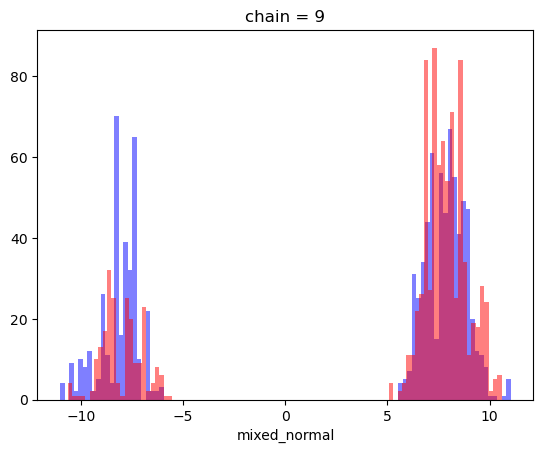

In [3]:
traces['DEMetro'].sel(chain=0).stack(sample=("draw")).posterior["mixed_normal"].plot.hist(bins=100, alpha=0.5, label="Metro", color="blue")
traces['DEMetro'].sel(chain=9).stack(sample=("draw")).posterior["mixed_normal"].plot.hist(bins=100, alpha=0.5, label="Metro", color="red")


In [ ]:

fig, ax = plt.subplots(2, 3, figsize=(15, 5))

for i, (sampler_name, trace) in enumerate(traces.items()):
    ax[0][i].hist(trace.posterior["mixed_normal"].values.flatten(), bins=50, alpha=0.5, label=sampler_name)
    ax[0][i].hist(iid_samples, bins=50, alpha=0.5, label="IID Samples")
    ax[0][i].set_title(sampler_name)
    ax[0][i].legend()

    


In [ ]:
ws_results = {}

traces = {}

r_hat_values = {}

for sampler_name in ["Metro","HMC","DEMetro"]:
    trace = framework.run_sampling(
        sampler_name,
        num_samples= samples_per_chain,
        num_chains=num_chains,
        #initvals=initvals,
        )
    ws_distance = framework.compute_wasserstein_distances(trace, iid_samples)
    ws_results[sampler_name] = ws_distance
    r_hat_value = az.rhat(trace)["mixed_normal"].item()
    r_hat_values[sampler_name] = r_hat_value

    print("dim der samples")
    print(trace.posterior["mixed_normal"].values.shape)

    print("dim der iid samples")
    print(iid_samples.shape)

    traces[sampler_name] = trace
    print(f"{sampler_name}: Wasserstein Distance = {ws_distance:.4f}")
    print(f"{sampler_name}: R-hat value = {r_hat_value:.4f}")



# Sort results
ranked_ws = sorted(ws_results.items(), key=lambda x: x[1])
ranked_r_hat = sorted(r_hat_values.items(), key=lambda x: x[1])


# Print ranked results
print("\n### Ranked Sampler Performance ###")
for rank, (sampler_name, ws_distance) in enumerate(ranked_ws, 1):
    print(f"{rank}. {sampler_name}: {ws_distance:.4f}")

print("\n### Ranked Sampler R-hat Values ###")
for rank, (sampler_name, r_hat) in enumerate(ranked_r_hat, 1):
    print(f"{rank}. {sampler_name}: {r_hat}")

In [ ]:
#initvals = [
#    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 1 starts near Mode 2
#    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 2 starts near Mode 2
#    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]}, # Chain 3 starts near Mode 2
#    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]}, # Chain 4 starts near Mode 2
#    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 5 starts near Mode 2
#    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 6 starts near Mode 2
#    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]}, # Chain 7 starts near Mode 2
#    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]}, # Chain 8 starts near Mode 2
#    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 9 starts near Mode 2
#    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 10 starts near Mode 2
#]

